# Protein Secondary Structure (Q3) Prediction: Data Prep and Modeling
Imports for the data prepration 

In [13]:
# ---------------- Top of file: imports ----------------
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import autocast, GradScaler

# ---------------- Phase 0: global seeding ----------------
SEED = 1337
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


# Reproducibility flags
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Optional (stricter, may slow down & restrict some ops):
# torch.use_deterministic_algorithms(True)


## Configuration and Data Loading

Here, we define global constants like the data file name and batch size. We then:
1.  Load the dataset from the specified `.csv` file.
2.  Perform an initial cleaning step by filtering out any protein sequences that contain the non-standard amino acid character (`*`).
3.  Select only the columns needed for this task (`seq`, `sst3`, `sst8`, `len`).

In [ ]:

# --- 1. Configuration and Data Loading ---
DATA_FILE = '2018-06-06-pdb-intersect-pisces.csv'
BATCH_SIZE = 64 
TEST_SIZE = 0.15 
VAL_SIZE = 0.15  

# Load the dataset
try:
    df = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE}' was not found. Please ensure it is in the working directory.")
    exit()

# Apply the fix for the SyntaxWarning using a raw string r'\*'
# Filter out sequences that contain the nonstandard amino acid mask ('*')
df_filtered = df[~df['seq'].str.contains(r'\*')].copy()

# Focus on core columns
df_filtered = df_filtered[['seq', 'sst3', 'sst8', 'len']]
print(f"Initial sequences: {len(df)}. Sequences after filtering: {len(df_filtered)}")

Initial sequences: 9078. Sequences after filtering: 8994


## Define Mappings and Tokenization

This block is for data tokenization. We create dictionaries (vocabularies) to map each character to a unique integer:
* **`aa_to_int`**: For the 20 standard amino acids (input features), plus a `PAD` token.
* **`q3_to_int`**: For the 3-class secondary structure labels (H, E, C), plus a `PAD` token.
* **`q8_to_int`**: For the 8-class labels (unused by the Q3 models, but prepped for completeness).

These mappings are then applied to the dataframe to create new columns (`seq_int`, `sst3_int`, `sst8_int`) containing the integer-encoded sequences. Finally, we find the longest sequence length in the entire dataset (`MAX_LEN`).

In [15]:
# --- 2. Define Mappings and Tokenization Parameters ---
AA_ALPHABET = list("ACDEFGHIKLMNPQRSTVWY")
Q3_ALPHABET = list("HEC") 
Q8_ALPHABET = list("HECBITGS") 

# Amino Acid (Input) Mappings
aa_to_int = {aa: i + 1 for i, aa in enumerate(AA_ALPHABET)}
aa_to_int['PAD'] = 0
AA_VOCAB_SIZE = len(aa_to_int)

# Q3 Label Mappings: Classes 0, 1, 2 and PAD 3
# H -> 0, E -> 1, C -> 2 (Standard PyTorch classification indices)
q3_to_int = {ss: i for i, ss in enumerate(Q3_ALPHABET)} 
q3_to_int['PAD'] = 3 # PAD index is moved to 3
Q3_NUM_CLASSES = len(Q3_ALPHABET) # 3
Q3_PAD_INDEX = q3_to_int['PAD'] # 3

# Q8 Label Mappings
q8_to_int = {ss: i + 1 for i, ss in enumerate(Q8_ALPHABET)}
q8_to_int['PAD'] = 0
Q8_NUM_CLASSES = len(Q8_ALPHABET) # 8
Q8_PAD_INDEX = q8_to_int['PAD'] # 0


# Apply tokenization to input (seq) and both labels (sst3, sst8)
df_filtered['seq_int'] = df_filtered['seq'].apply(
    lambda x: [aa_to_int.get(char, aa_to_int['PAD']) for char in x]
)
df_filtered['sst3_int'] = df_filtered['sst3'].apply(
    lambda x: [q3_to_int.get(char, q3_to_int['PAD']) for char in x]
)
df_filtered['sst8_int'] = df_filtered['sst8'].apply(
    lambda x: [q8_to_int.get(char, q8_to_int['PAD']) for char in x]
)

MAX_LEN = df_filtered['len'].max()
print(f"Max Sequence Length (MAX_LEN): {MAX_LEN}")

Max Sequence Length (MAX_LEN): 1632


## Padding Sequences

To train with batches, all sequences in a batch must be the same length. This cell defines a function `apply_padding` that:
1.  Pads shorter sequences with the `PAD` value up to `MAX_LEN`.
2.  Truncates any sequences that might be longer than `MAX_LEN`.

This function is then used to create the final NumPy arrays for our features (`X`) and labels (`Y_Q3`, `Y_Q8`).

In [16]:
def apply_padding(sequences, max_len, padding_value):
    """Pads integer sequences to a fixed length using post-padding (PyTorch convention)."""
    padded_sequences = []
    for seq in sequences:
        # Calculate how much padding is needed
        pad_amount = max_len - len(seq)
        if pad_amount > 0:
            # Post-pad: sequence + [padding_value, padding_value, ...]
            padded_seq = seq + [padding_value] * pad_amount
        else:
            # Truncate if sequence is longer than MAX_LEN
            padded_seq = seq[:max_len]
        padded_sequences.append(padded_seq)
    
    # Convert list of lists to a NumPy array
    return np.array(padded_sequences, dtype=np.int64) 

# Pad and convert to NumPy arrays (PyTorch requires long/int64 for indices)
X = apply_padding(df_filtered['seq_int'].tolist(), MAX_LEN, aa_to_int['PAD'])
Y_Q3 = apply_padding(df_filtered['sst3_int'].tolist(), MAX_LEN, q3_to_int['PAD'])
Y_Q8 = apply_padding(df_filtered['sst8_int'].tolist(), MAX_LEN, q8_to_int['PAD'])
print(f"Padded Features (X) shape: {X.shape}")

Padded Features (X) shape: (8994, 1632)


## Train-Validation-Test Split

Using `sklearn.model_selection.train_test_split`, we split the data into training, validation, and test sets. We perform two splits to get all three sets.

Finally, all NumPy arrays are converted to PyTorch `Long` Tensors, which is the required data type for embedding lookups and loss functions.

In [17]:
# --- 4. Train-Validation-Test Split and PyTorch Tensor Conversion ---
val_ratio_temp = VAL_SIZE / (1 - TEST_SIZE)

# Split 1: Get Test Set
X_temp, X_test, Y_Q3_temp, Y_Q3_test, Y_Q8_temp, Y_Q8_test = train_test_split(
    X, Y_Q3, Y_Q8, test_size=TEST_SIZE, random_state=42
)

# Split 2: Get Train and Validation Sets
X_train, X_val, Y_Q3_train, Y_Q3_val, Y_Q8_train, Y_Q8_val = train_test_split(
    X_temp, Y_Q3_temp, Y_Q8_temp, test_size=val_ratio_temp, random_state=42
)

# Convert all NumPy arrays to PyTorch Tensors
X_train_t = torch.from_numpy(X_train).long()
X_val_t = torch.from_numpy(X_val).long()
X_test_t = torch.from_numpy(X_test).long()

Y_Q3_train_t = torch.from_numpy(Y_Q3_train).long()
Y_Q3_val_t = torch.from_numpy(Y_Q3_val).long()
Y_Q3_test_t = torch.from_numpy(Y_Q3_test).long()

Y_Q8_train_t = torch.from_numpy(Y_Q8_train).long()
Y_Q8_val_t = torch.from_numpy(Y_Q8_val).long()
Y_Q8_test_t = torch.from_numpy(Y_Q8_test).long()

print(f"\nTraining set size: {len(X_train_t)} | Validation set size: {len(X_val_t)} | Test set size: {len(X_test_t)}")




Training set size: 6295 | Validation set size: 1349 | Test set size: 1350


## Create PyTorch DataLoaders

This cell prepares the data for the training loop:
1.  Creates `TensorDataset` objects, which bundle the (Features, Labels, Lengths) tensors together.
2.  Defines a custom `collate_triplet` function. This function tells the `DataLoader` how to combine a list of (X, Y, L) tuples into a single batch.
3.  Sets up the final `DataLoader`s for Q3 and Q8, which will feed batches to the model. The training loader is set to `shuffle=True`.

In [18]:
# --- 5. Create PyTorch DataLoaders for Q3 and Q8 (Phase 1: with lengths) ---
PAD_IDX = 0
# Fix lengths after padding
L_train_t = (X_train_t != PAD_IDX).sum(dim=1)
L_val_t   = (X_val_t   != PAD_IDX).sum(dim=1)
L_test_t  = (X_test_t  != PAD_IDX).sum(dim=1)

print("New length stats:",
      "train", L_train_t.min().item(), "-", L_train_t.max().item(),
      "val", L_val_t.min().item(), "-", L_val_t.max().item())
MAX_TRAIN_LEN = 768   # ← You can adjust or set to None to disable

if MAX_TRAIN_LEN is not None:
    # Apply masks for train / val / test
    mask_train = L_train_t <= MAX_TRAIN_LEN
    mask_val   = L_val_t   <= MAX_TRAIN_LEN
    mask_test  = L_test_t  <= MAX_TRAIN_LEN

    X_train_t, Y_Q3_train_t, Y_Q8_train_t, L_train_t = (
        X_train_t[mask_train],
        Y_Q3_train_t[mask_train],
        Y_Q8_train_t[mask_train],
        L_train_t[mask_train],
    )
    X_val_t, Y_Q3_val_t, Y_Q8_val_t, L_val_t = (
        X_val_t[mask_val],
        Y_Q3_val_t[mask_val],
        Y_Q8_val_t[mask_val],
        L_val_t[mask_val],
    )
    X_test_t, Y_Q3_test_t, Y_Q8_test_t, L_test_t = (
        X_test_t[mask_test],
        Y_Q3_test_t[mask_test],
        Y_Q8_test_t[mask_test],
        L_test_t[mask_test],
    )
    total_train_before = len(L_train_t) + (~mask_train).sum().item()  # optional sanity check
    kept_train = mask_train.sum().item()
    kept_val   = mask_val.sum().item()
    kept_test  = mask_test.sum().item()

    print(f"\n--- Trim Summary ---")
    print(f"MAX_TRAIN_LEN = {MAX_TRAIN_LEN}")
    print(f"Train kept: {kept_train}/{kept_train + (~mask_train).sum().item()} "
          f"({kept_train / (kept_train + (~mask_train).sum().item()):.2%})")
    print(f"Val kept:   {kept_val}/{kept_val + (~mask_val).sum().item()} "
          f"({kept_val / (kept_val + (~mask_val).sum().item()):.2%})")
    print(f"Test kept:  {kept_test}/{kept_test + (~mask_test).sum().item()} "
          f"({kept_test / (kept_test + (~mask_test).sum().item()):.2%})")

New length stats: train 20 - 1632 val 20 - 1122

--- Trim Summary ---
MAX_TRAIN_LEN = 768
Train kept: 6242/6295 (99.16%)
Val kept:   1336/1349 (99.04%)
Test kept:  1329/1350 (98.44%)


In [19]:

from torch.utils.data import TensorDataset, DataLoader

# Datasets now include lengths (X, Y, L)
train_ds_q3 = TensorDataset(X_train_t, Y_Q3_train_t, L_train_t)
val_ds_q3   = TensorDataset(X_val_t,   Y_Q3_val_t,   L_val_t)
test_ds_q3  = TensorDataset(X_test_t,  Y_Q3_test_t,  L_test_t)

train_ds_q8 = TensorDataset(X_train_t, Y_Q8_train_t, L_train_t)
val_ds_q8   = TensorDataset(X_val_t,   Y_Q8_val_t,   L_val_t)
test_ds_q8  = TensorDataset(X_test_t,  Y_Q8_test_t,  L_test_t)

# Collate: stack triplets as (x, y, lengths). No need to sort; we'll pack with enforce_sorted=False.
def collate_triplet(batch):
    xs, ys, ls = zip(*batch)
    return torch.stack(xs, 0), torch.stack(ys, 0), torch.stack(ls, 0)

# Stable defaults for Windows / notebooks
IN_NOTEBOOK = True   # set to False if running as a plain .py script
IS_WINDOWS  = (os.name == "nt")
NUM_WORKERS = 0 if (IN_NOTEBOOK or IS_WINDOWS) else 4
PIN_MEMORY  = torch.cuda.is_available()

# Base kwargs (when NUM_WORKERS=0, worker_init_fn/generator/persistent_workers are safely ignored)
dl_kwargs = dict(
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_triplet,
    # don't set persistent_workers / generator / worker_init_fn when workers=0
)

# Optional: deterministic shuffling when workers > 0 and not in notebook/Windows
g = torch.Generator()
g.manual_seed(SEED)
def _worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)

if NUM_WORKERS > 0:
    dl_kwargs.update(
        worker_init_fn=_worker_init_fn,
        generator=g,
        persistent_workers=True,
    )

# ---- Q3 loaders
train_loader_q3 = DataLoader(train_ds_q3, **{**dl_kwargs, "shuffle": True})
val_loader_q3   = DataLoader(val_ds_q3,   **dl_kwargs)
test_loader_q3  = DataLoader(test_ds_q3,  **dl_kwargs)

# ---- Q8 loaders (if you’re training Q8 too)
train_loader_q8 = DataLoader(train_ds_q8, **{**dl_kwargs, "shuffle": True})
val_loader_q8   = DataLoader(val_ds_q8,   **dl_kwargs)
test_loader_q8  = DataLoader(test_ds_q8,  **dl_kwargs)

print("\n--- Data Preparation Complete (Phase 1) ---")
print(f"DataLoaders (Batch Size: {BATCH_SIZE}, Workers: {NUM_WORKERS}, Pin: {PIN_MEMORY})")

# (Optional) quick smoke test to surface issues early:
xb, yb, lb = next(iter(train_loader_q3))
print("Example lengths:", lb[:10].tolist())
print("Mean:", lb.float().mean().item())
print("Mask coverage test:")
B, T = xb.shape
ar = torch.arange(T).unsqueeze(0).expand(B, T)
mask = ar >= lb.unsqueeze(1)
print("Mask coverage:", mask.float().mean().item())


--- Data Preparation Complete (Phase 1) ---
DataLoaders (Batch Size: 64, Workers: 0, Pin: True)
Example lengths: [38, 125, 339, 231, 180, 220, 157, 157, 206, 236]
Mean: 229.28125
Mask coverage test:
Mask coverage: 0.8595090508460999


In [20]:
print("Unique values in first training sample:", torch.unique(X_train_t[0])[:20])

Unique values in first training sample: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])


## Define Training Utilities and Helper Functions

This cell contains all the helper code needed to run the training and evaluation loops.
* **`EarlyStopper`**: A class to monitor validation loss and stop training if it doesn't improve for a set `patience` of epochs.
* **`_token_accuracy`**: A function to calculate per-token accuracy, making sure to **ignore** the `PAD` tokens so they don't artificially inflate the score.
* **`train_epoch`**: The function for a single training epoch. It handles the forward pass, loss calculation, backpropagation, and optimizer step. It uses `autocast` for mixed-precision training (AMP) and `GradScaler` to prevent underflow. It also uses `pack_padded_sequence` (via the model's forward pass) for efficiency.
* **`validate_epoch`**: The function for a single validation epoch. It runs the model in evaluation mode (`model.eval()`) and calculates the validation loss and accuracy.

In [21]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            return False
        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered! No improvement in {self.patience} epochs.")
                return True
            return False
        return False

@torch.no_grad()
def _token_accuracy(logits, targets, pad_idx):
    pred = logits.argmax(-1)             # (B,T)
    mask = (targets != pad_idx)
    total = mask.sum().item()
    if total == 0: return 0.0
    correct = (pred[mask] == targets[mask]).sum().item()
    return correct / total

def train_epoch(model, dataloader, loss_fn, optimizer, device, scaler, pad_idx=None):
    model.train()
    total_loss, n_batches = 0.0, 0
    for X, Y, L in dataloader:
        X = X.to(device, non_blocking=True)
        Y = Y.to(device, non_blocking=True)
        L = L.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        # AMP forward
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(X, L)                            # (B, T_b, C)
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]                             # align with unpacked length
            loss = loss_fn(logits.reshape(-1, logits.size(-1)),
                           Y_trim.reshape(-1))

        # scale + backward + step
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

@torch.no_grad()
def validate_epoch(model, dataloader, loss_fn, device, pad_idx):
    model.eval()
    tot_loss, tot_acc, n_batches = 0.0, 0.0, 0
    for X, Y, L in dataloader:
        X = X.to(device, non_blocking=True)
        Y = Y.to(device, non_blocking=True)
        L = L.to(device, non_blocking=True)
        # AMP on inference too (small speed boost)
        with autocast(enabled=torch.cuda.is_available()):

            logits = model(X, L)                            # (B, T_b, C)
            T_b = logits.size(1)
            Y_trim = Y[:, :T_b]
            loss = loss_fn(logits.reshape(-1, logits.size(-1)),
                           Y_trim.reshape(-1))
        acc = _token_accuracy(logits, Y_trim, pad_idx)

        tot_loss += loss.item()
        tot_acc  += acc
        n_batches += 1
    return tot_loss / max(n_batches, 1), tot_acc / max(n_batches, 1)

@torch.no_grad()
def test_model(model, dataloader, loss_fn, device, pad_idx):
    return validate_epoch(model, dataloader, loss_fn, device, pad_idx)


## Model 1: BiLSTM

This section defines and trains our first model, a Bidirectional LSTM.

In [22]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_size, num_lstm_layers,
                 output_size, dropout_rate=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_lstm_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(lstm_hidden_size * 2, output_size)

    def forward(self, x, lengths):
        emb = self.embedding(x)  # (B,T,E)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.bilstm(packed)
        # 👇 pad back to the input's full time dimension
        out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
        out = self.dropout(out)
        logits = self.classifier(out)  # (B, T_full, C)
        return logits


### BiLSTM Model Definition

This class defines the `BiLSTMModel` architecture:
1.  An `nn.Embedding` layer to convert integer tokens into dense vectors.
2.  An `nn.LSTM` layer (set to `bidirectional=True`) to capture sequential context from both directions.
3.  An `nn.Dropout` layer for regularization.
4.  An `nn.Linear` classifier head to project the LSTM's hidden state to the Q3 class dimension.

The `forward` method uses `pack_padded_sequence` and `pad_packed_sequence` to ensure the LSTM only performs computations on the non-padded parts of the sequences.

In [23]:
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np

# -----------------------
# Hyperparameters after tuning
# -----------------------
OPTIMAL_LR = 5e-3
HIDDEN_SIZE = 128        # ✅ fixed
EMBED_DIM = 128
NUM_LSTM_LAYERS = 2
DROPOUT_RATE = 0.3
MODEL_OUTPUT_CLASSES = Q3_NUM_CLASSES
NUM_EPOCHS = 25
PATIENCE = 7
WEIGHT_DECAY = 1e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training final BiLSTM with Hidden Size={HIDDEN_SIZE}, "
      f"LR={OPTIMAL_LR}, WD={WEIGHT_DECAY}, Device={device}")

# -----------------------
# Model setup
# -----------------------
model_q3 = BiLSTMModel(
    vocab_size=AA_VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    lstm_hidden_size=HIDDEN_SIZE,
    num_lstm_layers=NUM_LSTM_LAYERS,
    output_size=MODEL_OUTPUT_CLASSES,
    dropout_rate=DROPOUT_RATE
).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX)
optimizer = optim.Adam(model_q3.parameters(), lr=OPTIMAL_LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(enabled=torch.cuda.is_available())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

early_stopper = EarlyStopper(patience=PATIENCE)

# -----------------------
# Training Loop
# -----------------------
best_val_accuracy = 0.0
best_epoch = 0
model_save_path = "best_q3_bilstm_HS128.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    # Training step
    train_loss = train_epoch(
        model_q3, train_loader_q3, loss_fn, optimizer, device, scaler, Q3_PAD_INDEX
    )

    # Validation step
    val_loss, val_accuracy = validate_epoch(
        model_q3, val_loader_q3, loss_fn, device, Q3_PAD_INDEX
    )

    scheduler.step(val_loss)
    end_time = time.time()

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} ({end_time - start_time:.2f}s): "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_accuracy * 100:.2f}%, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model_q3.state_dict(), model_save_path)
        print(f"  --> Model saved (epoch {epoch}) with new best acc: {best_val_accuracy * 100:.2f}%")

    if early_stopper.early_stop(val_loss):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# -----------------------
# Final Evaluation
# -----------------------
print(f"\nTraining complete (best epoch {best_epoch}). Evaluating best model on Test Set...")

try:
    state = torch.load(model_save_path, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(model_save_path, map_location=device)
model_q3.load_state_dict(state)

test_loss, test_accuracy = test_model(
    model_q3, test_loader_q3, loss_fn, device, Q3_PAD_INDEX
)
print(f"FINAL TEST Q3-score: {test_accuracy * 100:.2f}% (best epoch {best_epoch})")


Training final BiLSTM with Hidden Size=128, LR=0.005, WD=1e-05, Device=cuda


C:\Users\rombo\AppData\Local\Temp\ipykernel_2792\3036864367.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
C:\Users\rombo\AppData\Local\Temp\ipykernel_2792\343010879.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
C:\Users\rombo\AppData\Local\Temp\ipykernel_2792\343010879.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01/25 (25.51s): Train Loss: 0.9159, Val Loss: 0.9057, Val Acc: 59.31%, LR: 0.005000
  --> Model saved (epoch 1) with new best acc: 59.31%
Epoch 02/25 (25.34s): Train Loss: 0.9081, Val Loss: 0.9035, Val Acc: 58.62%, LR: 0.005000
Epoch 03/25 (25.10s): Train Loss: 0.9281, Val Loss: 0.9522, Val Acc: 54.31%, LR: 0.005000
Epoch 04/25 (24.39s): Train Loss: 0.9380, Val Loss: 0.9695, Val Acc: 53.34%, LR: 0.005000
Epoch 05/25 (24.29s): Train Loss: 0.9886, Val Loss: 1.0034, Val Acc: 51.88%, LR: 0.002500
Epoch 06/25 (24.18s): Train Loss: 0.9881, Val Loss: 0.9952, Val Acc: 53.47%, LR: 0.002500
Epoch 07/25 (24.23s): Train Loss: 0.9975, Val Loss: 0.9980, Val Acc: 52.10%, LR: 0.002500
Epoch 08/25 (24.31s): Train Loss: 1.0036, Val Loss: 0.9966, Val Acc: 52.52%, LR: 0.001250
Epoch 09/25 (24.49s): Train Loss: 0.9986, Val Loss: 0.9969, Val Acc: 52.25%, LR: 0.001250
Early stopping triggered! No improvement in 7 epochs.
Early stopping triggered at epoch 9.

Training complete (best epoch 1). Evaluating

## Model 2: 1D CNN (Residual Blocks)

This section defines and trains our second model, a 1D Convolutional Neural Network.

In [11]:
import torch
import torch.nn as nn

class ResidualConvBlock(nn.Module):
    """Residual 1D convolutional block with same-length output."""
    def __init__(self, ch: int, kernel_size: int = 7, dilation: int = 1, dropout: float = 0.3):
        super().__init__()
        pad = (kernel_size // 2) * dilation
        self.conv_dw = nn.Conv1d(
            in_channels=ch,
            out_channels=ch,
            kernel_size=kernel_size,
            padding=pad,
            dilation=dilation,
            groups=ch,
            bias=False,
        )
        self.conv_pw = nn.Conv1d(ch, ch, kernel_size=1, bias=False)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.GroupNorm(1, ch)

    def forward(self, x):   # x: [B, C, T]
        residual = x
        h = self.conv_dw(x)
        h = self.act(h)
        h = self.dropout(h)
        h = self.conv_pw(h)
        h = self.norm(h)
        h = self.dropout(h)
        return residual + h


class CNN1DModel(nn.Module):
    """Token-level CNN for sequence labeling (e.g., Q3 classification)."""
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        conv_channels: int = 256,
        num_layers: int = 6,
        kernel_size: int = 7,
        dilations=(1, 2, 4, 8, 16, 32),
        dropout: float = 0.3,
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "Use an odd kernel size for same-padding"

        # normalize dilation list length
        if isinstance(dilations, int):
            dilations = [dilations] * num_layers
        elif len(dilations) < num_layers:
            dilations = list(dilations) + [dilations[-1]] * (num_layers - len(dilations))
        elif len(dilations) > num_layers:
            dilations = dilations[:num_layers]

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.input_proj = nn.Linear(embed_dim, conv_channels)
        self.blocks = nn.Sequential(
            *[ResidualConvBlock(conv_channels, kernel_size, d, dropout) for d in dilations]
        )
        self.norm = nn.LayerNorm(conv_channels)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(conv_channels, num_classes)

    def forward(self, x, lengths=None):
        emb = self.embedding(x)     # [B, T, E]
        h = self.input_proj(emb)    # [B, T, C]
        h = h.transpose(1, 2)       # [B, C, T] for convs
        h = self.blocks(h)          # [B, C, T]
        h = h.transpose(1, 2)       # [B, T, C]
        h = self.norm(h)
        h = self.dropout(h)
        logits = self.classifier(h) # [B, T, num_classes]
        return logits


### 1D CNN Model Definition

This defines a `CNN1DModel` using residual blocks.
* **`ResidualConvBlock`**: A custom module that uses depthwise-separable convolutions (`conv_dw` + `conv_pw`) and a residual connection (`return residual + h`). This is more efficient than a standard convolution. It also uses `GELU` activation and `GroupNorm`.
* **`CNN1DModel`**: The main model, which consists of:
    1.  An `nn.Embedding` layer.
    2.  A linear projection to match the embedding dimension to the `conv_channels`.
    3.  A sequence of `ResidualConvBlock`s with increasing `dilations` (e.g., 1, 2, 4, 8...). This allows the model to build a large receptive field and capture long-range dependencies, similar to a Transformer but more lightweight.
    4.  A final classifier head.

In [12]:
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np

# -----------------------
# Hyperparameters / Config
# -----------------------
OPTIMAL_LR = 16e-5         # safer LR based on your sweep stability
CONV_CHANNELS = 512
NUM_CONV_LAYERS = 7
KERNEL_SIZE = 7
DILATIONS = (1, 2, 4, 8, 16, 32)
DROPOUT_RATE = 0.178

NUM_EPOCHS = 25
PATIENCE = 7
WEIGHT_DECAY = 1.13e-6

MODEL_OUTPUT_CLASSES = Q3_NUM_CLASSES  # per-token Q3 classes

# very important: PAD index for the AMINO ACID tokens (the input IDs)
# not the Q3 label pad
AA_PAD_INDEX = aa_to_int["PAD"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Training final CNN1D with conv_channels={CONV_CHANNELS}, "
    f"LR={OPTIMAL_LR}, WD={WEIGHT_DECAY}, Device={device}"
)

# -----------------------
# Model setup
# -----------------------
model_q3 = CNN1DModel(
    vocab_size=AA_VOCAB_SIZE,
    embed_dim=192,
    num_classes=MODEL_OUTPUT_CLASSES,
    pad_idx=AA_PAD_INDEX,        # FIXED: use AA pad index, not Q3_PAD_INDEX
    conv_channels=CONV_CHANNELS,
    num_layers=NUM_CONV_LAYERS,
    kernel_size=KERNEL_SIZE,
    dilations=DILATIONS,
    dropout=DROPOUT_RATE
).to(device)

print(f"CNN1DModel initialized. Output classes = {MODEL_OUTPUT_CLASSES}")

# -----------------------
# Loss / Optim / Scheduler / Early Stopper
# -----------------------
# We ignore padded label positions when computing CE loss.
loss_fn = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX)

optimizer = optim.Adam(
    model_q3.parameters(),
    lr=OPTIMAL_LR,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler(enabled=torch.cuda.is_available())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',     # we're minimizing val_loss
    factor=0.5,     # halve LR
    patience=2      # after 2 non-improving steps
)

early_stopper = EarlyStopper(patience=PATIENCE)

# -----------------------
# Training Loop
# -----------------------
best_val_accuracy = 0.0
best_epoch = 0
model_save_path = "best_q3_cnn1d.pth"  # renamed so you don't overwrite BiLSTM

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    # Training step (one full epoch)
    train_loss = train_epoch(
        model_q3,
        train_loader_q3,
        loss_fn,
        optimizer,
        device,
        scaler,
        Q3_PAD_INDEX  # for masking accuracy etc. inside train_epoch
    )

    # Validation step
    val_loss, val_accuracy = validate_epoch(
        model_q3,
        val_loader_q3,
        loss_fn,
        device,
        Q3_PAD_INDEX
    )

    # Step the LR scheduler based on validation loss
    scheduler.step(val_loss)

    end_time = time.time()

    # Log progress
    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} ({end_time - start_time:.2f}s): "
        f"Train Loss: {train_loss:.4f}, "
        f"Val Loss: {val_loss:.4f}, "
        f"Val Acc: {val_accuracy * 100:.2f}%, "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    # Save best checkpoint based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model_q3.state_dict(), model_save_path)
        print(
            f"  --> Model saved (epoch {epoch}) "
            f"with new best acc: {best_val_accuracy * 100:.2f}%"
        )

    # Early stopping check (based on validation loss curve)
    if early_stopper.early_stop(val_loss):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# -----------------------
# Final Evaluation
# -----------------------
print(
    f"\nTraining complete (best epoch {best_epoch}). "
    f"Evaluating best CNN1D model on Test Set..."
)

# Reload best model (the checkpoint from the best val accuracy)
try:
    state = torch.load(model_save_path, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(model_save_path, map_location=device)

model_q3.load_state_dict(state)

test_loss, test_accuracy = test_model(
    model_q3,
    test_loader_q3,
    loss_fn,
    device,
    Q3_PAD_INDEX
)

print(
    f"FINAL TEST Q3-score: {test_accuracy * 100:.2f}% "
    f"(best epoch {best_epoch})"
)


Training final CNN1D with conv_channels=512, LR=0.00016, WD=1.13e-06, Device=cuda
CNN1DModel initialized. Output classes = 3


C:\Users\rombo\AppData\Local\Temp\ipykernel_2792\4033851823.py:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
C:\Users\rombo\AppData\Local\Temp\ipykernel_2792\343010879.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
C:\Users\rombo\AppData\Local\Temp\ipykernel_2792\343010879.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01/25 (53.44s): Train Loss: 0.9354, Val Loss: 0.8349, Val Acc: 62.80%, LR: 0.000160
  --> Model saved (epoch 1) with new best acc: 62.80%
Epoch 02/25 (50.57s): Train Loss: 0.8356, Val Loss: 0.7836, Val Acc: 65.37%, LR: 0.000160
  --> Model saved (epoch 2) with new best acc: 65.37%
Epoch 03/25 (51.70s): Train Loss: 0.7806, Val Loss: 0.7471, Val Acc: 67.66%, LR: 0.000160
  --> Model saved (epoch 3) with new best acc: 67.66%
Epoch 04/25 (52.32s): Train Loss: 0.7534, Val Loss: 0.7255, Val Acc: 68.59%, LR: 0.000160
  --> Model saved (epoch 4) with new best acc: 68.59%
Epoch 05/25 (50.25s): Train Loss: 0.7380, Val Loss: 0.7318, Val Acc: 68.04%, LR: 0.000160
Epoch 06/25 (51.44s): Train Loss: 0.7319, Val Loss: 0.7077, Val Acc: 69.53%, LR: 0.000160
  --> Model saved (epoch 6) with new best acc: 69.53%
Epoch 07/25 (52.01s): Train Loss: 0.7326, Val Loss: 0.7345, Val Acc: 68.43%, LR: 0.000160
Epoch 08/25 (50.56s): Train Loss: 0.7215, Val Loss: 0.7209, Val Acc: 69.10%, LR: 0.000160
Epoch 09/2

### Optuna Study for CNN


In [18]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import math
import sys
import gc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import plotly # Explicitly import plotly

# ===================================================================
# MODEL DEFINITIONS
# (Copied from your cell to ensure they are in scope)
# ===================================================================

class ResidualConvBlock(nn.Module):
    """Residual 1D convolutional block with same-length output."""
    def __init__(self, ch: int, kernel_size: int = 7, dilation: int = 1, dropout: float = 0.3):
        super().__init__()
        pad = (kernel_size // 2) * dilation
        self.conv_dw = nn.Conv1d(
            in_channels=ch,
            out_channels=ch,
            kernel_size=kernel_size,
            padding=pad,
            dilation=dilation,
            groups=ch,
            bias=False,
        )
        self.conv_pw = nn.Conv1d(ch, ch, kernel_size=1, bias=False)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.GroupNorm(1, ch) # Using GroupNorm(1, ch) as a stand-in for LayerNorm-like op on [B,C,T]

    def forward(self, x):  # x: [B, C, T]
        residual = x
        h = self.conv_dw(x)
        h = self.act(h)
        h = self.dropout(h)
        h = self.conv_pw(h)
        h = self.norm(h)
        h = self.dropout(h)
        return residual + h


class CNN1DModel(nn.Module):
    """Token-level CNN for sequence labeling (e.g., Q3 classification)."""
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        conv_channels: int = 256,
        num_layers: int = 6,
        kernel_size: int = 7,
        dilations=(1, 2, 4, 8, 16, 32),
        dropout: float = 0.3,
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "Use an odd kernel size for same-padding"

        # normalize dilation list length
        if isinstance(dilations, int):
            dilations = [dilations] * num_layers
        elif len(dilations) < num_layers:
            dilations = list(dilations) + [dilations[-1]] * (num_layers - len(dilations))
        elif len(dilations) > num_layers:
            dilations = dilations[:num_layers]

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.input_proj = nn.Linear(embed_dim, conv_channels)
        self.blocks = nn.Sequential(
            *[ResidualConvBlock(conv_channels, kernel_size, d, dropout) for d in dilations]
        )
        self.norm = nn.LayerNorm(conv_channels) # Operates on [B, T, C]
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(conv_channels, num_classes)

    def forward(self, x, lengths=None):
        # The 'lengths' arg is accepted to match the helper function, but not used by this CNN model.
        emb = self.embedding(x)   # [B, T, E]
        h = self.input_proj(emb)   # [B, T, C]
        h = h.transpose(1, 2)      # [B, C, T] for convs
        h = self.blocks(h)         # [B, C, T]
        h = h.transpose(1, 2)      # [B, T, C] for layernorm
        h = self.norm(h)
        h = self.dropout(h)
        logits = self.classifier(h) # [B, T, num_classes]
        return logits


# ===========================================================
# OPTUNA SCRIPT
# ===========================================================

# --- CONFIGURATION ---
MAX_EPOCHS_PER_TRIAL = 10 
N_TRIALS = 30
# ---------------------

def objective(trial):
    """
    This is the main function that Optuna will call for each trial.
    It defines, trains, and validates one model with a set of hyperparameters.
    """
    
    model_q3 = None
    optimizer = None
    criterion = None
    scheduler = None
    scaler = None
    early_stopper = None

    try:
        # --- 1. Define Hyperparameter Search Space ---
        lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
        embed_dim = trial.suggest_categorical("embed_dim", [128, 192, 256])
        conv_channels = trial.suggest_categorical("conv_channels", [128, 256, 512])
        num_layers = trial.suggest_int("num_layers", 4, 10)
        kernel_size = trial.suggest_categorical("kernel_size", [5, 7, 9])
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        
        dilations = [2**(i % 6) for i in range(num_layers)]

        # --- 2. Create Model and Optimizer ---
        try:
            AA_PAD_INDEX = aa_to_int["PAD"]
        except NameError:
            print("ERROR: 'aa_to_int' is not defined. Please run data prep cells.", file=sys.stderr)
            AA_PAD_INDEX = 0 

        model_q3 = CNN1DModel(
            vocab_size=AA_VOCAB_SIZE,
            embed_dim=embed_dim,
            num_classes=Q3_NUM_CLASSES,
            pad_idx=AA_PAD_INDEX,
            conv_channels=conv_channels,
            num_layers=num_layers,
            kernel_size=kernel_size,
            dilations=dilations,
            dropout=dropout
        ).to(DEVICE)

        criterion = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX)
        
        optimizer = optim.Adam(
            model_q3.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        scaler = GradScaler(enabled=torch.cuda.is_available())

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2
        )
        
        early_stopper = EarlyStopper(patience=4) 

        best_val_accuracy = 0.0

        # --- 3. Training & Validation Loop ---
        for epoch in range(MAX_EPOCHS_PER_TRIAL):
            
            # We assume train_epoch is defined in a previous cell
            train_loss = train_epoch(
                model_q3, train_loader_q3, criterion, optimizer,
                DEVICE, scaler, Q3_PAD_INDEX
            )
            
            # We assume validate_epoch is defined in a previous cell
            val_loss, val_accuracy = validate_epoch(
                model_q3, val_loader_q3, criterion, DEVICE, Q3_PAD_INDEX
            )

            scheduler.step(val_loss)
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

            trial.report(val_accuracy, epoch)
            
            if trial.should_prune():
                raise optuna.TrialPruned(f"Pruned at epoch {epoch+1}")
            
            if early_stopper.early_stop(val_loss):
                break

        return best_val_accuracy

    except optuna.TrialPruned as e:
        raise e
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}", file=sys.stderr)
        return 0.0 
    
    finally:
        # --- CRITICAL: Memory Cleanup ---
        del model_q3, optimizer, criterion, scheduler, scaler, early_stopper
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


# ===========================================================
# START THE HYPERPARAMETER STUDY
# ===========================================================

print("Starting Optuna hyperparameter study for CNN1DModel...")
# ... (rest of study setup) ...

pruner = optuna.pruners.MedianPruner(n_warmup_steps=3) 
study = optuna.create_study(direction="maximize", pruner=pruner)

try:
    study.optimize(
        objective, 
        n_trials=N_TRIALS, 
        timeout=7200 
    )
except KeyboardInterrupt:
    print("\nStudy interrupted by user.")


# ===========================================================
# SHOW RESULTS
# ===========================================================

print("\nHyperparameter study complete!")

if len(study.trials) > 0:
    print("\n--- Best Trial ---")
    try:
        print(f"  Value (Max ValAcc): {study.best_value:.4f}")
        print("  Params: ")
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")
    except ValueError:
        print("No trials completed successfully.")

    # --- THIS IS THE UPDATED/FIXED VISUALIZATION BLOCK ---
    try:
        # 1. Show the optimization history
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.write_html("optuna_history.html")
        
        # 2. Show the importance of each hyperparameter
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.write_html("optuna_param_importances.html")
        
        # 3. Show which parameters work well together
        plot_params = [param for param in study.best_params.keys()]
        
        if len(plot_params) >= 2:
            fig3 = optuna.visualization.plot_contour(study, params=plot_params[:2])
            fig3.write_html("optuna_contour_plot.html")

        print("\nSuccessfully saved visualization plots to HTML files:")
        print("  - optuna_history.html")
        print("  - optuna_param_importances.html")
        print("  - optuna_contour_plot.html")
        print("You can open these files in your browser.")
        
        # Try to show inline, but fail gracefully
        fig1.show()
        fig2.show()
        if 'fig3' in locals():
            fig3.show()

    except ImportError:
        print("\nInstall 'plotly' to see visualizations:")
        print("  pip install plotly")
    except Exception as e:
        # This will catch the 'Mime type rendering' error
        print(f"\nCould not display visualizations inline: {e}")
        print("Please open the saved .html files to view plots.")
else:
    print("No trials were completed. Please check for errors in the logs above.")

[I 2025-11-08 03:17:30,791] A new study created in memory with name: no-name-4fe7ad9b-73ca-4454-9e0c-628ad3ad52b2


Starting Optuna hyperparameter study for CNN1DModel...


C:\Users\rombo\AppData\Local\Temp\ipykernel_32036\1229544348.py:158: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.

C:\Users\rombo\AppData\Local\Temp\ipykernel_32036\343010879.py:39: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

C:\Users\rombo\AppData\Local\Temp\ipykernel_32036\343010879.py:65: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

[I 2025-11-08 03:19:25,274] Trial 0 finished with value: 0.681130893735947 and parameters: {'lr': 0.00010189668387013413, 'embed_dim': 192, 'conv_channels': 128, 'num_layers': 7, 'kernel_size': 9, 'dropout': 0.23920273344905196, 'weight_decay': 1.2349707480459837e-06}. Best is trial 0 with value: 0.681130893735947.


Early stopping triggered! No improvement in 4 epochs.


[I 2025-11-08 03:24:08,321] Trial 1 finished with value: 0.6188058537914826 and parameters: {'lr': 0.0005758070547209411, 'embed_dim': 256, 'conv_channels': 256, 'num_layers': 9, 'kernel_size': 9, 'dropout': 0.2589538918500549, 'weight_decay': 0.00019595505447689317}. Best is trial 0 with value: 0.681130893735947.
[I 2025-11-08 03:25:19,100] Trial 2 finished with value: 0.6026932383643345 and parameters: {'lr': 3.1959750239679406e-05, 'embed_dim': 256, 'conv_channels': 128, 'num_layers': 4, 'kernel_size': 7, 'dropout': 0.1610090619312287, 'weight_decay': 5.2795121735957684e-05}. Best is trial 0 with value: 0.681130893735947.


Early stopping triggered! No improvement in 4 epochs.


[I 2025-11-08 03:26:15,692] Trial 3 finished with value: 0.4456245442138331 and parameters: {'lr': 0.008087988676596963, 'embed_dim': 128, 'conv_channels': 128, 'num_layers': 7, 'kernel_size': 9, 'dropout': 0.19340706882745745, 'weight_decay': 0.0007508861344784514}. Best is trial 0 with value: 0.681130893735947.


Early stopping triggered! No improvement in 4 epochs.


[I 2025-11-08 03:27:30,848] Trial 4 finished with value: 0.42971080513193627 and parameters: {'lr': 1.332864150672071e-05, 'embed_dim': 128, 'conv_channels': 128, 'num_layers': 10, 'kernel_size': 5, 'dropout': 0.4679275629243417, 'weight_decay': 4.799861541931009e-06}. Best is trial 0 with value: 0.681130893735947.
[I 2025-11-08 03:30:29,650] Trial 5 pruned. Pruned at epoch 6
[I 2025-11-08 03:35:00,075] Trial 6 finished with value: 0.6816713894723926 and parameters: {'lr': 0.00019243229477838568, 'embed_dim': 192, 'conv_channels': 512, 'num_layers': 4, 'kernel_size': 7, 'dropout': 0.20018453515639206, 'weight_decay': 6.579376499779151e-06}. Best is trial 6 with value: 0.6816713894723926.
[I 2025-11-08 03:37:43,606] Trial 7 pruned. Pruned at epoch 6
[I 2025-11-08 03:40:59,357] Trial 8 pruned. Pruned at epoch 6
[I 2025-11-08 03:43:39,507] Trial 9 pruned. Pruned at epoch 4


Early stopping triggered! No improvement in 4 epochs.


[I 2025-11-08 03:48:08,863] Trial 10 finished with value: 0.6732621510603087 and parameters: {'lr': 0.0005189288741227459, 'embed_dim': 192, 'conv_channels': 512, 'num_layers': 4, 'kernel_size': 7, 'dropout': 0.10004121251989795, 'weight_decay': 1.2605516961597425e-05}. Best is trial 6 with value: 0.6816713894723926.
[I 2025-11-08 03:49:58,229] Trial 11 finished with value: 0.6841961931917031 and parameters: {'lr': 0.0001262538927723636, 'embed_dim': 192, 'conv_channels': 128, 'num_layers': 7, 'kernel_size': 7, 'dropout': 0.220544572457886, 'weight_decay': 1.0071768810778317e-06}. Best is trial 11 with value: 0.6841961931917031.
[I 2025-11-08 04:01:57,561] Trial 12 finished with value: 0.7038342358974121 and parameters: {'lr': 0.0001607836697539104, 'embed_dim': 192, 'conv_channels': 512, 'num_layers': 7, 'kernel_size': 7, 'dropout': 0.17827534592221744, 'weight_decay': 1.1338796653380442e-06}. Best is trial 12 with value: 0.7038342358974121.


Early stopping triggered! No improvement in 4 epochs.


[I 2025-11-08 04:03:37,709] Trial 13 finished with value: 0.6828622472869293 and parameters: {'lr': 0.0010952876732579855, 'embed_dim': 192, 'conv_channels': 128, 'num_layers': 8, 'kernel_size': 7, 'dropout': 0.36989316155004404, 'weight_decay': 1.0180332467093955e-06}. Best is trial 12 with value: 0.7038342358974121.
[I 2025-11-08 04:10:11,593] Trial 14 finished with value: 0.690837381903366 and parameters: {'lr': 0.0002146968797882793, 'embed_dim': 192, 'conv_channels': 512, 'num_layers': 6, 'kernel_size': 7, 'dropout': 0.12487756389689336, 'weight_decay': 2.658045461200203e-06}. Best is trial 12 with value: 0.7038342358974121.


Early stopping triggered! No improvement in 4 epochs.


[I 2025-11-08 04:16:46,663] Trial 15 finished with value: 0.6899935670023439 and parameters: {'lr': 0.0003832257825285789, 'embed_dim': 192, 'conv_channels': 512, 'num_layers': 6, 'kernel_size': 7, 'dropout': 0.10047536176265404, 'weight_decay': 2.885443489132919e-06}. Best is trial 12 with value: 0.7038342358974121.
[I 2025-11-08 04:19:24,629] Trial 16 pruned. Pruned at epoch 4
[W 2025-11-08 04:37:44,513] Trial 17 failed with parameters: {'lr': 0.001559669409325519, 'embed_dim': 256, 'conv_channels': 512, 'num_layers': 8, 'kernel_size': 7, 'dropout': 0.1494870312680988, 'weight_decay': 2.6285986665505356e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\rombo\anaconda3\envs\neuralnet\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\rombo\AppData\Local\Temp\ipykernel_32036\1229544348.py", line 172, in objective
    train_loss = train_epoch(
  File "C:\User


Study interrupted by user.

Hyperparameter study complete!

--- Best Trial ---
  Value (Max ValAcc): 0.7038
  Params: 
    lr: 0.0001607836697539104
    embed_dim: 192
    conv_channels: 512
    num_layers: 7
    kernel_size: 7
    dropout: 0.17827534592221744
    weight_decay: 1.1338796653380442e-06

Successfully saved visualization plots to HTML files:
  - optuna_history.html
  - optuna_param_importances.html
  - optuna_contour_plot.html
You can open these files in your browser.

Could not display visualizations inline: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Please open the saved .html files to view plots.


## 11. Model 3: Transformer Encoder

This section defines and trains our third model, a standard Transformer.


This cell defines the `PSSTransformer` model, which is a standard Transformer Encoder stack.
* **`PositionalEncoding`**: A standard class to inject sequence position information into the embeddings.
* **`PSSTransformer`**: The main model, consisting of:
    1.  An `nn.Embedding` layer.
    2.  The `PositionalEncoding` layer.
    3.  A standard `nn.TransformerEncoder` (which is a stack of `nn.TransformerEncoderLayer`s).
    4.  A final classifier head.

The `forward` method creates the `src_key_padding_mask` from the `lengths` tensor. This mask tells the Transformer's self-attention mechanism to ignore the `PAD` tokens.

This cell also contains the **full training loop** for this model, including a weighted loss calculation (`weights = (1.0 / label_counts)`) to handle class imbalance.

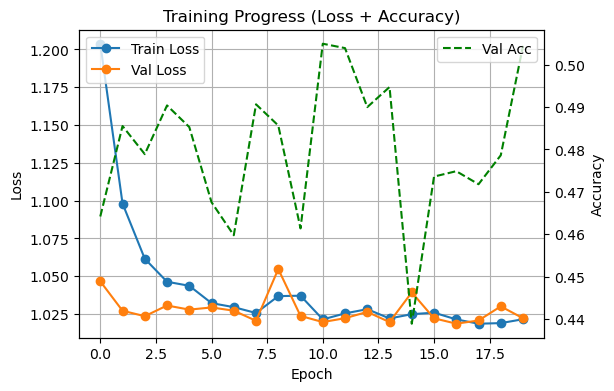

✅ Training complete with tuned LR (3e-3)!


In [24]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter

# -------------------------------
# Model
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x * math.sqrt(x.size(-1)) + self.pe[:T, :]


class PSSTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, num_classes,
                 pad_idx=0, dropout=0.1, max_len=1632):
        super().__init__()
        self.pad_idx = pad_idx
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.posenc = PositionalEncoding(d_model, max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x, lengths):
        B, T = x.size()
        device = x.device
        ar = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        key_padding_mask = ar >= lengths.unsqueeze(1)
        h = self.embed(x)
        h = self.posenc(h)
        h = self.dropout(h)
        h = self.encoder(h, src_key_padding_mask=key_padding_mask)
        h = self.dropout(h)
        return self.classifier(h)

# -------------------------------
# Setup
# -------------------------------
PAD_IDX = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_q3 = PSSTransformer(
    vocab_size=AA_VOCAB_SIZE,
    d_model=192, n_heads=6, n_layers=3, d_ff=768,
    num_classes=Q3_NUM_CLASSES, pad_idx=PAD_IDX,
    dropout=0.1, max_len=X_train_t.size(1)
).to(DEVICE)

# Weighted loss (balances coil/helix/sheet)
label_counts = torch.zeros(Q3_NUM_CLASSES)
for _, y, _ in train_loader_q3:
    label_counts += torch.bincount(y[y != Q3_PAD_INDEX].flatten(), minlength=Q3_NUM_CLASSES)
weights = (1.0 / label_counts).to(DEVICE)
weights = weights / weights.sum() * Q3_NUM_CLASSES
print("Class weights:", weights.tolist())

criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=Q3_PAD_INDEX, label_smoothing=0.05)

# Tuned LR
MAX_LR = 3e-3
optimizer = torch.optim.AdamW(model_q3.parameters(), lr=MAX_LR, weight_decay=1e-2)
EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR,
    steps_per_epoch=len(train_loader_q3),
    epochs=EPOCHS
)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

# -------------------------------
# Training loop
# -------------------------------
ACCUM_STEPS, CLIP_NORM = 4, 1.0
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model_q3.train(); total_loss = 0.0
    pbar = tqdm(train_loader_q3, desc=f"Epoch {epoch+1}/{EPOCHS} — Training", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (X, Y, L) in enumerate(pbar, 1):
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model_q3(X, L)
            loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0 or step == len(train_loader_q3):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_q3.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{loss.item() * ACCUM_STEPS:.4f}")

    avg_train_loss = total_loss / len(train_loader_q3)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model_q3.eval(); val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast("cuda", enabled=torch.cuda.is_available()):
        for X, Y, L in val_loader_q3:
            X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
            logits = model_q3(X, L)
            val_loss += criterion(logits.transpose(1, 2), Y).item()
            preds = logits.argmax(dim=-1)
            mask = Y != Q3_PAD_INDEX
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader_q3)
    val_acc = correct / total
    val_losses.append(avg_val_loss); val_accs.append(val_acc)

    tqdm.write(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, ValAcc={val_acc*100:.2f}%")

    # Live plot
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(val_accs, 'g--', label='Val Acc')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    plt.title('Training Progress (Loss + Accuracy)')
    plt.show()

print("✅ Training complete with tuned LR (3e-3)!")


In [25]:
# After your validation loop (inside the same epoch)
val_correct = 0
val_total = 0

with torch.no_grad(), autocast("cuda", enabled=torch.cuda.is_available()):
    for X, Y, L in val_loader_q3:
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        logits = model_q3(X, L)
        preds = logits.argmax(dim=-1)

        # Mask out PADs (where Y == Q3_PAD_INDEX)
        mask = Y != Q3_PAD_INDEX
        val_correct += (preds[mask] == Y[mask]).sum().item()
        val_total += mask.sum().item()

val_acc = val_correct / val_total
print(f"Validation Accuracy: {val_acc:.3f}")


Validation Accuracy: 0.504


## Model 4: Hybrid (CNN + BiLSTM + Transformer)

This section defines and trains our fourth and most complex model, which combines all three previous architectures.


This cell defines the `CNN_BiLSTM_Transformer` model. In its `forward` pass, data flows through:
1.  **Embedding + Positional Encoding**
2.  **CNN Block**: A 1D CNN captures local features.
3.  **BiLSTM Block**: The output of the CNN is fed into a BiLSTM to capture sequential dependencies.
4.  **Transformer Block**: The output of the BiLSTM is fed into a Transformer Encoder to capture global, long-range context.
5.  **Classifier Head**: A final linear layer produces the Q3 predictions.

This cell also contains the full training loop for this hybrid model.

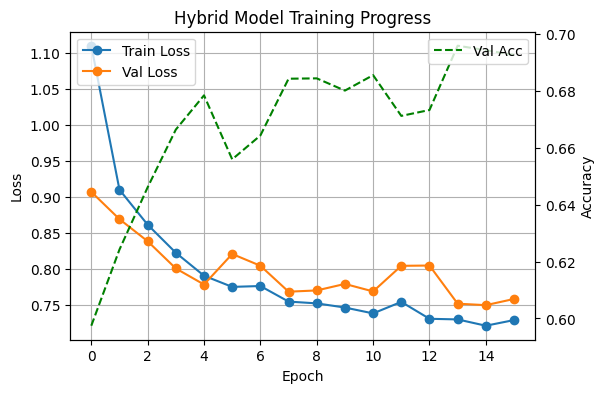

Epoch 17: Train=0.7032, Val=0.7728, ValAcc=68.46%
⏹️ Early stopping at epoch 17
✅ Loaded best model with ValAcc=69.60%


In [ ]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# -------------------------------
# Hybrid model (CNN + BiLSTM + Transformer)
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1632):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x * math.sqrt(x.size(-1)) + self.pe[:T, :]


class CNN_BiLSTM_Transformer(nn.Module):
    def __init__(self, vocab_size, num_classes, pad_idx=0,
                 d_model=192, cnn_channels=128, lstm_hidden=256,
                 n_heads=6, n_layers=3, d_ff=768, dropout=0.1, max_len=1632):
        super().__init__()
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.posenc = PositionalEncoding(d_model, max_len)

        self.cnn_block = nn.Sequential(
            nn.Conv1d(d_model, cnn_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Conv1d(cnn_channels, d_model, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(d_model),
        )

        self.bilstm = nn.LSTM(d_model, lstm_hidden, num_layers=1,
                              batch_first=True, bidirectional=True)
        lstm_out_dim = lstm_hidden * 2

        enc_layer = nn.TransformerEncoderLayer(
            d_model=lstm_out_dim, nhead=n_heads,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True, activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_out_dim, num_classes)

        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x, lengths):
        B, T = x.size()
        device = x.device
        mask = torch.arange(T, device=device).unsqueeze(0) >= lengths.unsqueeze(1)

        h = self.embedding(x)
        h = self.posenc(h)
        h = h.transpose(1, 2)
        h = self.cnn_block(h).transpose(1, 2)

        packed = nn.utils.rnn.pack_padded_sequence(
            h, lengths.cpu(), batch_first=True, enforce_sorted=False)
        h, _ = self.bilstm(packed)
        h, _ = nn.utils.rnn.pad_packed_sequence(h, batch_first=True, total_length=T)

        h = self.transformer(h, src_key_padding_mask=mask)
        h = self.dropout(h)
        return self.classifier(h)


# -------------------------------
# Training setup
# -------------------------------
PAD_IDX = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_hybrid = CNN_BiLSTM_Transformer(
    vocab_size=AA_VOCAB_SIZE, num_classes=Q3_NUM_CLASSES,
    pad_idx=PAD_IDX, d_model=192, cnn_channels=128,
    lstm_hidden=96, n_heads=6, n_layers=2, d_ff=512,
    dropout=0.1, max_len=X_train_t.size(1)
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model_hybrid.parameters(), lr=3e-3, weight_decay=1e-2)
EPOCHS, ACCUM_STEPS, CLIP_NORM = 25, 4, 1.0
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-3,
    steps_per_epoch=len(train_loader_q3), epochs=EPOCHS
)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

# Early stopping
patience, best_val_acc, no_improve, early_stop = 3, 0.0, 0, False
save_path = "best_hybrid_model.pt"

train_losses, val_losses, val_accs = [], [], []

# -------------------------------
# Training loop
# -------------------------------
for epoch in range(EPOCHS):
    model_hybrid.train()
    total_loss = 0.0
    pbar = tqdm(train_loader_q3, desc=f"Epoch {epoch+1}/{EPOCHS} — Training", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (X, Y, L) in enumerate(pbar, 1):
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model_hybrid(X, L)
            loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0 or step == len(train_loader_q3):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_hybrid.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{loss.item()*ACCUM_STEPS:.4f}")

    avg_train_loss = total_loss / len(train_loader_q3)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model_hybrid.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast("cuda", enabled=torch.cuda.is_available()):
        for X, Y, L in val_loader_q3:
            X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
            logits = model_hybrid(X, L)
            val_loss += criterion(logits.transpose(1, 2), Y).item()
            preds = logits.argmax(dim=-1)
            mask = (Y != Q3_PAD_INDEX)
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader_q3)
    val_acc = correct / total
    val_losses.append(avg_val_loss); val_accs.append(val_acc)

    tqdm.write(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, ValAcc={val_acc*100:.2f}%")

    # --- Early stopping ---
    if val_acc > best_val_acc:
        best_val_acc, no_improve = val_acc, 0
        torch.save(model_hybrid.state_dict(), save_path)
        tqdm.write(f"✅ Saved new best model (ValAcc={val_acc*100:.2f}%)")
    else:
        no_improve += 1
        if no_improve >= patience:
            tqdm.write(f"⏹️ Early stopping at epoch {epoch+1}")
            early_stop = True
            break
    

    # --- Live plot ---
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(val_accs, 'g--', label='Val Acc')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    plt.title('Hybrid Model Training Progress')
    plt.show()

if early_stop:
    model_hybrid.load_state_dict(torch.load(save_path))
    print(f"✅ Loaded best model with ValAcc={best_val_acc*100:.2f}%")
else:
    print(f"✅ Training complete. Best ValAcc={best_val_acc*100:.2f}%")


In [13]:
torch.cuda.empty_cache()

## Hyperparameter Tuning (Optuna) for Hybrid Model

This cell uses the `Optuna` library to perform an automated hyperparameter search for the `CNN_BiLSTM_Transformer` model.

* The `objective` function defines the search space (e.g., for `lr`, `d_model`, `lstm_hidden`). It then trains a model with a set of trial parameters for a few epochs and returns the validation accuracy.
* `optuna.create_study` and `study.optimize` run the search.
* **Note**: This cell includes a `finally` block with `gc.collect()` and `torch.cuda.empty_cache()`. This is a critical fix to prevent memory leaks between trials, which is a common issue when using Optuna with PyTorch.

In [17]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import torch.nn.functional as F
import gc # Import the garbage collector

# ===================================================================
# MODEL DEFINITIONS (Copied from your previous cell)
# ===================================================================

class PositionalEncoding(nn.Module):
    """Adds positional encoding to the input embeddings."""
    def __init__(self, d_model, max_len=1632):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        T = x.size(1)
        return x * math.sqrt(self.pe.size(-1)) + self.pe[:T, :]


class CNN_BiLSTM_Transformer(nn.Module):
    """
    Hybrid model architecture combining CNN, BiLSTM, and Transformer Encoder
    for sequence prediction.
    """
    def __init__(self, vocab_size, num_classes, pad_idx=0,
                 d_model=192, cnn_channels=128, lstm_hidden=128,
                 n_heads=8, n_layers=2, d_ff=512,
                 dropout=0.1, max_len=1632):
        super().__init__()
        assert (lstm_hidden * 2) % n_heads == 0, "lstm_hidden*2 must be divisible by n_heads"
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.dropout_emb = nn.Dropout(dropout)
        self.posenc = PositionalEncoding(d_model, max_len)
        self.cnn_block = nn.Sequential(
            nn.Conv1d(d_model, cnn_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Conv1d(cnn_channels, d_model, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(d_model),
        )
        self.dropout_cnn = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(d_model, lstm_hidden, num_layers=1,
                              batch_first=True, bidirectional=True)
        lstm_out_dim = lstm_hidden * 2
        enc_layer = nn.TransformerEncoderLayer(
            d_model=lstm_out_dim, nhead=n_heads,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True, activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout_final = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_out_dim, num_classes)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x, lengths):
        B, T = x.size()
        device = x.device
        mask = torch.arange(T, device=device).unsqueeze(0) >= lengths.unsqueeze(1)
        h = self.embedding(x)
        h = self.dropout_emb(self.posenc(h))
        h = h.transpose(1, 2)
        h = self.dropout_cnn(self.cnn_block(h)).transpose(1, 2)
        packed = nn.utils.rnn.pack_padded_sequence(h, lengths.cpu(), batch_first=True, enforce_sorted=False)
        h, _ = self.bilstm(packed)
        h, _ = nn.utils.rnn.pad_packed_sequence(h, batch_first=True, total_length=T)
        h = self.transformer(h, src_key_padding_mask=mask)
        h = self.dropout_final(h)
        return self.classifier(h)

# ===========================================================
# OPTUNA SCRIPT
# ===========================================================

MAX_EPOCHS_PER_TRIAL = 8 
N_TRIALS = 20

def objective(trial):
    """
    This is the main function that Optuna will call for each trial.
    It defines, trains, and validates one model with a set of hyperparameters.
    """
    
    # Initialize variables to None for the 'finally' block
    model_hybrid = None
    optimizer = None
    criterion = None
    scheduler = None
    scaler = None

    try:
        # --- 1. Define Hyperparameter Search Space ---
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        d_model = trial.suggest_categorical("d_model", [128, 192, 256])
        lstm_hidden = trial.suggest_categorical("lstm_hidden", [64, 128, 256])
        n_layers = trial.suggest_int("n_layers", 1, 3) # Transformer layers
        dropout = trial.suggest_float("dropout", 0.1, 0.3)
        
        n_heads = 8 
        if (lstm_hidden * 2) % n_heads != 0:
            raise optuna.TrialPruned(f"lstm_hidden*2 ({lstm_hidden*2}) not divisible by n_heads ({n_heads})")

        # --- 2. Create Model and Optimizer ---
        try:
            max_len = X_train_t.size(1)
        except NameError:
            print("Warning: 'X_train_t' not found. Defaulting max_len to 1632.", file=sys.stderr)
            max_len = 1632 

        model_hybrid = CNN_BiLSTM_Transformer(
            vocab_size=AA_VOCAB_SIZE, 
            num_classes=Q3_NUM_CLASSES,
            pad_idx=Q3_PAD_INDEX, 
            d_model=d_model, 
            cnn_channels=128, 
            lstm_hidden=lstm_hidden, 
            n_heads=n_heads, 
            n_layers=n_layers, 
            d_ff=lstm_hidden * 2 * 4, 
            dropout=dropout, 
            max_len=max_len
        ).to(DEVICE)

        criterion = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX, label_smoothing=0.05)
        optimizer = torch.optim.AdamW(model_hybrid.parameters(), lr=lr, weight_decay=1e-3)
        
        ACCUM_STEPS, CLIP_NORM = 4, 1.0
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=lr, steps_per_epoch=len(train_loader_q3), epochs=MAX_EPOCHS_PER_TRIAL
        )
        scaler = GradScaler(enabled=torch.cuda.is_available())

        best_val_acc = 0.0

        # --- 3. Training & Validation Loop ---
        for epoch in range(MAX_EPOCHS_PER_TRIAL):
            model_hybrid.train()
            total_loss = 0.0
            
            for step, (X, Y, L) in enumerate(train_loader_q3, 1):
                X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
                
                with autocast(device_type="cuda" if DEVICE.type == "cuda" else "cpu", enabled=torch.cuda.is_available()):
                    logits = model_hybrid(X, L)
                    loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
                
                scaler.scale(loss).backward()

                if step % ACCUM_STEPS == 0 or step == len(train_loader_q3):
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model_hybrid.parameters(), CLIP_NORM)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    scheduler.step()

                total_loss += loss.item() * ACCUM_STEPS

            # --- Validation ---
            model_hybrid.eval()
            val_loss, correct, total = 0.0, 0, 0
            with torch.no_grad(), autocast(device_type="cuda" if DEVICE.type == "cuda" else "cpu", enabled=torch.cuda.is_available()):
                for X, Y, L in val_loader_q3:
                    X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
                    logits = model_hybrid(X, L)
                    val_loss += criterion(logits.transpose(1, 2), Y).item()
                    preds = logits.argmax(dim=-1)
                    mask = (Y != Q3_PAD_INDEX)
                    correct += (preds[mask] == Y[mask]).sum().item()
                    total += mask.sum().item()

            avg_val_loss = val_loss / len(val_loader_q3)
            val_acc = correct / total if total > 0 else 0
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc

            trial.report(val_acc, epoch)
            
            if trial.should_prune():
                raise optuna.TrialPruned(f"Pruned at epoch {epoch+1}")

        return best_val_acc

    except optuna.TrialPruned as e:
        raise e
    except Exception as e:
        print(f"Trial failed with error: {e}", file=sys.stderr)
        return 0.0 # Return a bad score
    
    finally:
        # --- THIS IS THE FIX ---
        # Manually delete large objects and clear the GPU cache
        # This ensures memory is freed before the next trial starts.
        del model_hybrid, optimizer, criterion, scheduler, scaler
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# ===========================================================
# START THE HYPERPARAMETER STUDY
# ===========================================================

print("Starting Optuna hyperparameter study...")
print(f"This will run {N_TRIALS} trials, each up to {MAX_EPOCHS_PER_TRIAL} epochs.")

pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)

try:
    study.optimize(
        objective, 
        n_trials=N_TRIALS, 
        timeout=10200 # 1 hour timeout
    )
except KeyboardInterrupt:
    print("Study interrupted by user.")


# ===========================================================
# SHOW RESULTS
# ===========================================================

print("\nHyperparameter study complete!")

if len(study.trials) > 0:
    print("\n--- Best Trial ---")
    try:
        print(f"  Value (Max ValAcc): {study.best_value:.4f}")
        print("  Params: ")
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")
    except ValueError:
        print("No trials completed successfully.")

    try:
        import plotly
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.show()
        
        plot_params = [param for param in ["lr", "d_model", "lstm_hidden", "n_layers", "dropout"] 
                       if param in study.best_params]
        
        if len(plot_params) >= 2:
            fig3 = optuna.visualization.plot_contour(study, params=plot_params[:2])
            fig3.show()

    except ImportError:
        print("\nInstall 'plotly' to see visualizations:")
        print("  pip install plotly")
    except (ValueError, RuntimeError) as e:
        print(f"\nCould not display visualizations: {e}")
else:
    print("No trials were completed. Please check for errors in the logs above.")

[I 2025-11-08 00:15:09,102] A new study created in memory with name: no-name-65110c09-8587-41d4-9a8a-c678880490c0


Starting Optuna hyperparameter study...
This will run 20 trials, each up to 8 epochs.


[I 2025-11-08 00:39:12,912] Trial 0 finished with value: 0.675092208829233 and parameters: {'lr': 0.0008370549458640759, 'd_model': 128, 'lstm_hidden': 256, 'n_layers': 2, 'dropout': 0.1602840586358047}. Best is trial 0 with value: 0.675092208829233.
[I 2025-11-08 00:49:27,651] Trial 1 finished with value: 0.6807546548030977 and parameters: {'lr': 0.0010743963944474797, 'd_model': 192, 'lstm_hidden': 128, 'n_layers': 3, 'dropout': 0.1761845649456724}. Best is trial 1 with value: 0.6807546548030977.
[I 2025-11-08 01:59:21,025] Trial 2 finished with value: 0.6595719735858144 and parameters: {'lr': 0.0003533161711441098, 'd_model': 256, 'lstm_hidden': 256, 'n_layers': 3, 'dropout': 0.1429065391859934}. Best is trial 1 with value: 0.6807546548030977.
[I 2025-11-08 02:05:19,717] Trial 3 finished with value: 0.6583298477762145 and parameters: {'lr': 0.0005600095145249983, 'd_model': 128, 'lstm_hidden': 64, 'n_layers': 2, 'dropout': 0.20669170350093535}. Best is trial 1 with value: 0.68075465


Hyperparameter study complete!

--- Best Trial ---
  Value (Max ValAcc): 0.6943
  Params: 
    lr: 0.004700802590382269
    d_model: 192
    lstm_hidden: 128
    n_layers: 1
    dropout: 0.11229132013253441

Could not display visualizations: Mime type rendering requires nbformat>=4.2.0 but it is not installed


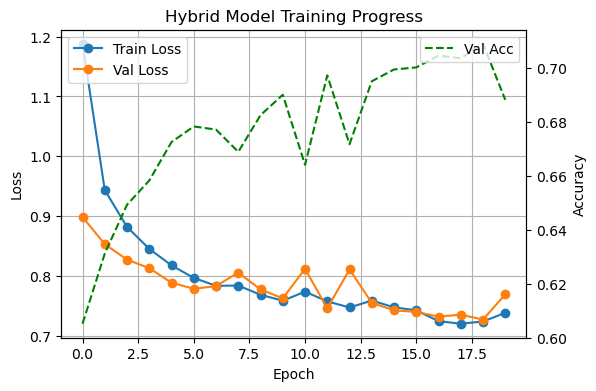

KeyboardInterrupt: 

In [26]:
import math, torch, torch.nn as nn
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ===========================================================
# MODEL DEFINITION
# ===========================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1632):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x * math.sqrt(x.size(-1)) + self.pe[:T, :]


class CNN_BiLSTM_Transformer(nn.Module):
    def __init__(self, vocab_size, num_classes, pad_idx=0,
                 d_model=192, cnn_channels=128, lstm_hidden=128,
                 n_heads=8, n_layers=1, d_ff=512,
                 dropout=0.1, max_len=1632):
        super().__init__()
        assert (lstm_hidden * 2) % n_heads == 0, "lstm_hidden*2 must be divisible by n_heads"
        self.pad_idx = pad_idx

        # --- Embedding ---
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.dropout_emb = nn.Dropout(dropout)
        self.posenc = PositionalEncoding(d_model, max_len)

        # --- CNN Block ---
        self.cnn_block = nn.Sequential(
            nn.Conv1d(d_model, cnn_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Conv1d(cnn_channels, d_model, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(d_model),
        )
        self.dropout_cnn = nn.Dropout(dropout)

        # --- BiLSTM ---
        self.bilstm = nn.LSTM(d_model, lstm_hidden, num_layers=1,
                              batch_first=True, bidirectional=True)
        lstm_out_dim = lstm_hidden * 2

        # --- Transformer Encoder ---
        enc_layer = nn.TransformerEncoderLayer(
            d_model=lstm_out_dim, nhead=n_heads,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True, activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout_final = nn.Dropout(dropout)

        # --- Classifier ---
        self.classifier = nn.Linear(lstm_out_dim, num_classes)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x, lengths):
        B, T = x.size()
        device = x.device
        mask = torch.arange(T, device=device).unsqueeze(0) >= lengths.unsqueeze(1)

        h = self.embedding(x)
        h = self.dropout_emb(self.posenc(h))
        h = h.transpose(1, 2)
        h = self.dropout_cnn(self.cnn_block(h)).transpose(1, 2)

        packed = nn.utils.rnn.pack_padded_sequence(h, lengths.cpu(), batch_first=True, enforce_sorted=False)
        h, _ = self.bilstm(packed)
        h, _ = nn.utils.rnn.pad_packed_sequence(h, batch_first=True, total_length=T)

        h = self.transformer(h, src_key_padding_mask=mask)
        h = self.dropout_final(h)
        return self.classifier(h)



# ===========================================================
# TRAINING CONFIG
# ===========================================================
PAD_IDX = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_hybrid = CNN_BiLSTM_Transformer(
    vocab_size=AA_VOCAB_SIZE, num_classes=Q3_NUM_CLASSES,
    pad_idx=PAD_IDX, d_model=192, cnn_channels=128,
    lstm_hidden=128, n_heads=8, n_layers=2, d_ff=512,
    dropout=0.15, max_len=X_train_t.size(1)
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=Q3_PAD_INDEX, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model_hybrid.parameters(), lr=3e-3, weight_decay=1e-3)

EPOCHS, ACCUM_STEPS, CLIP_NORM, patience = 30, 4, 1.0, 4
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-3, steps_per_epoch=len(train_loader_q3), epochs=EPOCHS
)
scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

best_val_acc, no_improve, early_stop = 0.0, 0, False
save_path = "best_hybrid_model.pt"

train_losses, val_losses, val_accs = [], [], []

# ===========================================================
# TRAINING LOOP
# ===========================================================
for epoch in range(EPOCHS):
    model_hybrid.train()
    total_loss = 0.0
    pbar = tqdm(train_loader_q3, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for step, (X, Y, L) in enumerate(pbar, 1):
        X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
        with autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model_hybrid(X, L)
            loss = criterion(logits.transpose(1, 2), Y) / ACCUM_STEPS
        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0 or step == len(train_loader_q3):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_hybrid.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{loss.item()*ACCUM_STEPS:.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")

    avg_train_loss = total_loss / len(train_loader_q3)
    train_losses.append(avg_train_loss)

    # -----------------------
    # Validation
    # -----------------------
    model_hybrid.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad(), autocast("cuda", enabled=torch.cuda.is_available()):
        for X, Y, L in val_loader_q3:
            X, Y, L = X.to(DEVICE), Y.to(DEVICE), L.to(DEVICE)
            logits = model_hybrid(X, L)
            val_loss += criterion(logits.transpose(1, 2), Y).item()
            preds = logits.argmax(dim=-1)
            mask = (Y != Q3_PAD_INDEX)
            correct += (preds[mask] == Y[mask]).sum().item()
            total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader_q3)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    tqdm.write(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}, ValAcc={val_acc*100:.2f}%")

    min_delta = 0.002  # require +0.2% improvement in validation accuracy
    if val_acc > best_val_acc + min_delta:
        best_val_acc, no_improve = val_acc, 0
        torch.save(model_hybrid.state_dict(), save_path)
        tqdm.write(f"✅ Saved new best model (ValAcc={val_acc*100:.2f}%)")
    else:
        no_improve += 1
        tqdm.write(f"⚠️ No improvement for {no_improve}/{patience} epochs (ValAcc={val_acc*100:.2f}%)")
        if no_improve >= patience:
            tqdm.write(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

    # --- Live Plot ---
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(val_accs, 'g--', label='Val Acc')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    plt.title('Hybrid Model Training Progress')
    plt.show()

if early_stop:
    model_hybrid.load_state_dict(torch.load(save_path))
    print(f"✅ Loaded best model with ValAcc={best_val_acc*100:.2f}%")
else:
    print(f"✅ Training complete. Best ValAcc={best_val_acc*100:.2f}%")
